## Cloning the repository and importing required modules

Cloning the repository containing the YOLOv1 “from scratch” implementation from GitHub and navigate to the project folder.

We then import:

- YOLOv1: the YOLOv1 model class.
- yolo_loss: the YOLOv1-specific loss function.
- YoloDataset: a custom dataset class for loading YOLO images and labels.
- src.utils: various utility functions for processing and visualization.
- torch and DataLoader: for handling tensors and batching data with PyTorch.

In [30]:
!git clone https://github.com/LucasAurouet/yolov1-from-scratch.git

%cd yolov1-from-scratch

from src.yolo_model import YOLOv1
from src.loss import yolo_loss
from src.dataloader import YoloDataset
import src.utils
import torch
from torch.utils.data import DataLoader

Cloning into 'yolov1-from-scratch'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 188 (delta 119), reused 127 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (188/188), 1020.11 KiB | 19.25 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/kaggle/working/yolov1-from-scratch/yolov1-from-scratch/yolov1-from-scratch/yolov1-from-scratch


## Setting the device for training

Checking if a GPU is available for PyTorch and set the computation device accordingly.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


## Defining the YOLOv1 configuration

Main hyperparameters for the YOLOv1 model:

- S: the number of grid cells along each image dimension (7 × 7 grid).
- B: the number of bounding boxes predicted per grid cell (2 in this case).
- C: the number of classes in the dataset (52).

In [32]:
config = {
    'S': 12,
    'B': 2,
    'C': 52,
}

## Initializing the YOLOv1 model

Creating an instance of the YOLOv1 model using the configuration defined earlier.

YOLOv1(**config) unpacks the config dictionary and passes the hyperparameters (S, B, C).

model.to(device) moves the model to the selected computation device (GPU or CPU) so that all subsequent tensor operations and training steps occur on the correct hardware.

In [33]:
model = YOLOv1(**config)
model = model.to(device)

## Creating the dataset and visualizing an example

Initializing our custom YOLO dataset:

data_dir points to the folder containing the training images and their corresponding label files.

YoloDataset(data_dir, config) creates a dataset object that will handle loading images, reading label files, and converting annotations into YOLOv1 tensors.

We then retrieve a single example from the dataset:

example_img, example_label = dataset.\_\_getitem\_\_(0) gets the first image and its corresponding label tensor.
src.utils.draw_output displays the image along with the bounding boxes and class labels.

- The t=0.0 argument controls the confidence threshold for drawing boxes (here set to 0 to show all boxes).
- transform=False ensures we visualize the raw image without any additional preprocessing.

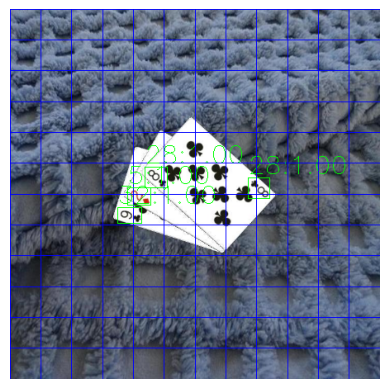

In [34]:
data_dir = r'/kaggle/input/playing-cards-darknet/train'

dataset = YoloDataset(data_dir, config)

example_img, example_label = dataset.__getitem__(0)
src.utils.draw_output(example_img, example_label, t=0.0, config=config, transform=False)

## Optimizer configuration

In [35]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=5e-4
)

## Training the YOLOv1 model

Setting up up and runnin a training loop for YOLOv1:

DataLoader wraps the YoloDataset to provide mini-batches of data with parallel loading (num_workers) for efficiency.

pin_memory=True can speed up GPU transfers for CUDA-enabled devices.

yolo_loss(...) calculates the YOLOv1 loss, taking into account coordinate loss (lambda_coord=5) and no-object confidence penalty (lambda_noobj).

In [36]:
epochs = 150

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

model.train()

for epoch in range(epochs):
    for images_batch, labels_batch in dataloader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        output_batch = model.forward(images_batch)
        loss = yolo_loss(output_batch, labels_batch, **config, lambda_coord=5, lambda_noobj=0.1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 7.2924
Epoch 2/100, Loss: 7.1685
Epoch 3/100, Loss: 7.0349
Epoch 4/100, Loss: 7.4007
Epoch 5/100, Loss: 7.2048
Epoch 6/100, Loss: 7.3356
Epoch 7/100, Loss: 6.9909
Epoch 8/100, Loss: 6.7337
Epoch 9/100, Loss: 6.5206
Epoch 10/100, Loss: 6.6115
Epoch 11/100, Loss: 6.7924
Epoch 12/100, Loss: 7.0592
Epoch 13/100, Loss: 6.9729
Epoch 14/100, Loss: 7.0956
Epoch 15/100, Loss: 6.6006
Epoch 16/100, Loss: 6.6634
Epoch 17/100, Loss: 6.4889
Epoch 18/100, Loss: 7.0627
Epoch 19/100, Loss: 6.5900
Epoch 20/100, Loss: 6.2696
Epoch 21/100, Loss: 5.4780
Epoch 22/100, Loss: 4.9489
Epoch 23/100, Loss: 4.7576
Epoch 24/100, Loss: 4.5775
Epoch 25/100, Loss: 4.3079
Epoch 26/100, Loss: 4.3261
Epoch 27/100, Loss: 4.2624
Epoch 28/100, Loss: 3.9759
Epoch 29/100, Loss: 3.8088
Epoch 30/100, Loss: 3.5493
Epoch 31/100, Loss: 3.4730
Epoch 32/100, Loss: 3.5185
Epoch 33/100, Loss: 3.2961
Epoch 34/100, Loss: 3.1852
Epoch 35/100, Loss: 3.1956
Epoch 36/100, Loss: 3.0499
Epoch 37/100, Loss: 2.7577
Epoch 38/1

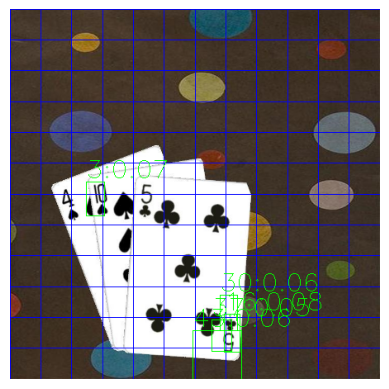

In [39]:
model.eval()

test_img, test_label = dataset.__getitem__(1)

test_tensor = test_img.unsqueeze(0).to(device)
output = model(test_tensor).squeeze(0)

src.utils.draw_output(test_img, output, t=0.05, config=config, transform=True)